In [1]:
import torch
import numpy as np

In [3]:
from InteractionNetwork import InteractionNetwork

In [4]:
model=InteractionNetwork()
model.load_state_dict(torch.load("../data/model/IN_best_dec10.pth"))

<All keys matched successfully>

In [5]:
model

InteractionNetwork(
  (interactionnetwork): MetaLayer(
      edge_model=EdgeBlock(
    (edge_mlp): Sequential(
      (0): Linear(in_features=96, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
  ),
      node_model=NodeBlock(
    (node_mlp_1): Sequential(
      (0): Linear(in_features=176, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
    (node_mlp_2): Sequential(
      (0): Linear(in_features=176, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
  ),
      global_model=GlobalBlock(
    (global_mlp): Sequential

In [31]:
layers=list(model.children())
layers=list(map(lambda x:list(x.children()),layers))[0]

In [121]:
edge_layers=dict(layers[0].edge_mlp.named_children())
edge_layers

{'0': Linear(in_features=96, out_features=128, bias=True),
 '1': BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 '2': ReLU(),
 '3': Linear(in_features=128, out_features=128, bias=True)}

In [44]:
import yaml
from GraphDataset import GraphDataset


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



with open('definitions.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']


file_names=["/teams/DSC180A_FA20_A00/b06particlephysics/train/ntuple_merged_10.root"]
graph_dataset = GraphDataset('data', features, labels, spectators, n_events=10000, n_events_merge=1000, 
                             file_names=file_names)

In [47]:
b=graph_dataset[0]

display(len(b))

951

In [61]:
g=b[0]
g.batch=torch.tensor(np.zeros(g.x.shape[0]).astype("int64"))
g

Data(batch=[38], edge_index=[2, 1406], u=[1, 2], x=[38, 48], y=[1, 2])

In [48]:
# LRP rule
rho=lambda x:x    # LRP-0

In [49]:
# from textbook
def relprop(a,layer,R,epsilon=1e-9):    # what is R?
    z=epsilon+rho(layer).forward(a)
    s=R/(z+1e-9)
    (z*s.data).sum().backward()
    c=a.grad   # what is a.grad? got None
    R=a*c
    return R

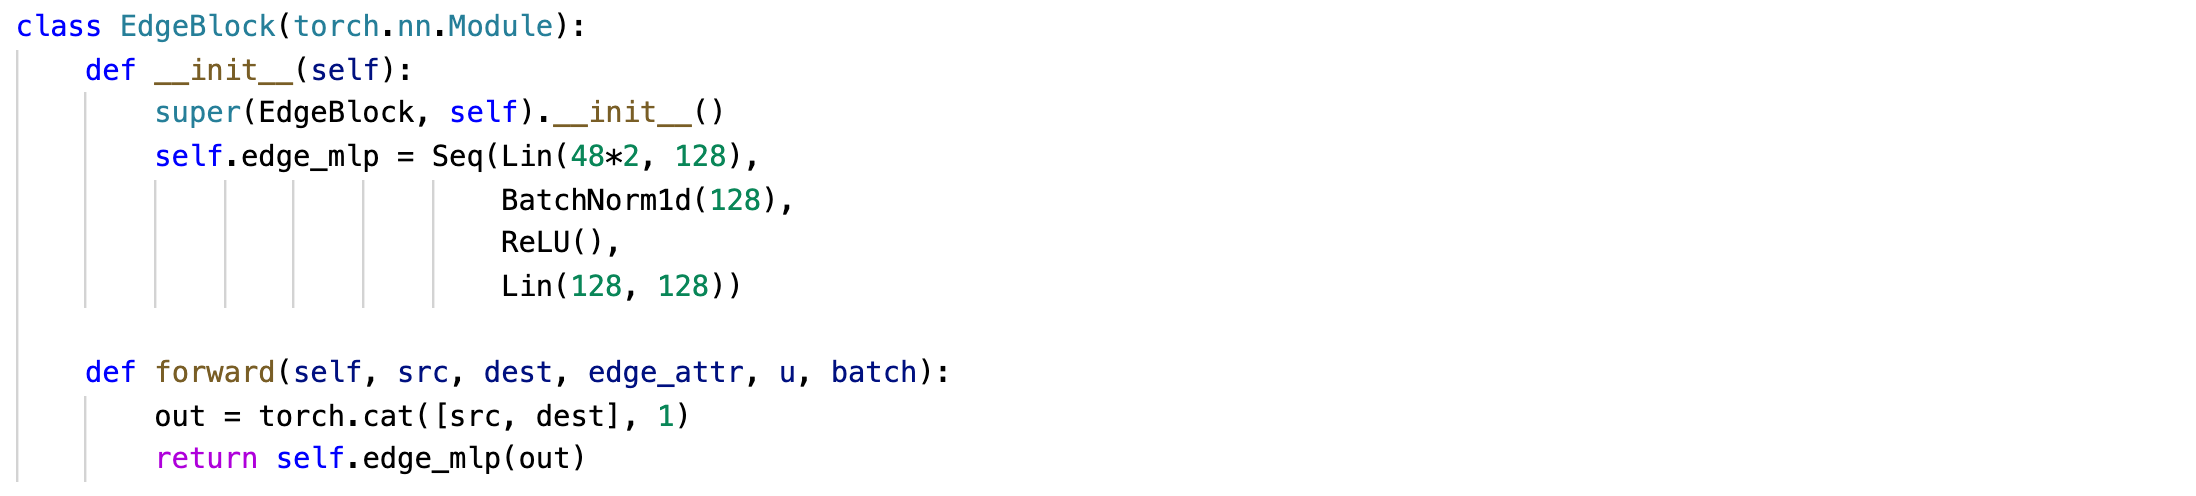

In [127]:
row,col=g.edge_index

# input data of EdgeBlock forward
x=torch.cat([g.x[row],g.x[col]],1)
a=edge_layers["2"].forward(edge_layers["1"].forward(edge_layers["0"].forward(x)))

# block output
R=layers[0].forward(g.x[row],g.x[col],None,None,None)

In [128]:
# what is R?
relprop(a,edge_layers["3"],R)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  


TypeError: unsupported operand type(s) for *: 'Tensor' and 'NoneType'